**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [79]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [80]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
PATH = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

In [81]:
#@ READING DATASET:
# PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [83]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [84]:
df.median_house_value

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [85]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df.median_house_value = np.log1p(df.median_house_value)
df.median_house_value

0        13.022766
1        12.789687
2        12.771673
3        12.740520
4        12.743154
           ...    
20635    11.265758
20636    11.252872
20637    11.432810
20638    11.346883
20639    11.400887
Name: median_house_value, Length: 20640, dtype: float64

In [86]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY


In [87]:
target = "median_house_value"

In [89]:
df_full_train, df_test = train_test_split(df,test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df,test_size=0.25, random_state=1)
y_full_train = df_full_train.median_house_value.values
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values
del df_full_train[target]
del df_test[target]
del df_train[target]
del df_val[target]
df_full_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
15961,-122.43,37.71,52.0,1410.0,286.0,879.0,282.0,3.1908,NEAR BAY
1771,-122.35,37.95,42.0,1485.0,290.0,971.0,303.0,3.6094,NEAR BAY
16414,-121.24,37.90,16.0,50.0,10.0,20.0,6.0,2.6250,INLAND
5056,-118.35,34.02,34.0,5218.0,1576.0,3538.0,1371.0,1.5143,<1H OCEAN
8589,-118.39,33.89,38.0,1851.0,332.0,750.0,314.0,7.3356,<1H OCEAN


In [91]:
cols = select_cols.copy()
cols.remove(target)
cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

- We will use `DictVectorizer` to turn train and validation into matrices.

In [92]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dv = DictVectorizer(sparse=False)
x_train_dicts = df_train[cols].to_dict(orient="records")
x_val_dicts = df_val[cols].to_dict(orient="records")
x_test_dicts = df_test[cols].to_dict(orient="records")

In [93]:
x_train = dv.fit_transform(x_train_dicts)
x_val = dv.transform(x_val_dicts)
x_test = dv.transform(x_test_dicts)

**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [94]:
#@ TRAINING THE REGRESSION MODEL:

dtr = DecisionTreeRegressor(max_depth=1, random_state=1)
dtr.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=1, random_state=1)

In [95]:
#@ INSPECTION:
print(export_text(dtr, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



- Which feature is used for splitting the data?

- Answer: INLAND 

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [96]:
#@ TRAINING RANDOM FOREST MODEL:
rfr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rfr.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [98]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rfr.predict(x_val)
rmse = mean_squared_error(y_val, y_pred)
rmse

0.0598439493163337

- What's the RMSE of this model on validation?

- Answer: 0.06

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [101]:
#@ TRAINING THE RANDOM FOREST MODEL:

results = []

for n_estimators in np.arange(10, 201, 10):
  rfr = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
  rfr.fit(x_train, y_train)
  y_pred = rfr.predict(x_val)
  rmse = mean_squared_error(y_val, y_pred)
  print(f"n_estimators = {n_estimators} rmse = {rmse}")
  results.append((n_estimators, rmse))


n_estimators = 10 rmse = 0.0598439493163337
n_estimators = 20 rmse = 0.05727504501948288
n_estimators = 30 rmse = 0.05608073843929573
n_estimators = 40 rmse = 0.055732591364672915
n_estimators = 50 rmse = 0.05535425090825278
n_estimators = 60 rmse = 0.055190161933916036
n_estimators = 70 rmse = 0.05526950337114548
n_estimators = 80 rmse = 0.055099589573087415
n_estimators = 90 rmse = 0.055057721992464274
n_estimators = 100 rmse = 0.05507821546173712
n_estimators = 110 rmse = 0.055090323763640536
n_estimators = 120 rmse = 0.05508769144250959
n_estimators = 130 rmse = 0.054949926674426365
n_estimators = 140 rmse = 0.05490066776546086
n_estimators = 150 rmse = 0.05488453931838531
n_estimators = 160 rmse = 0.05489107913726082
n_estimators = 170 rmse = 0.05488716500803245
n_estimators = 180 rmse = 0.05485283122197738
n_estimators = 190 rmse = 0.054828731245575
n_estimators = 200 rmse = 0.05481432680357404


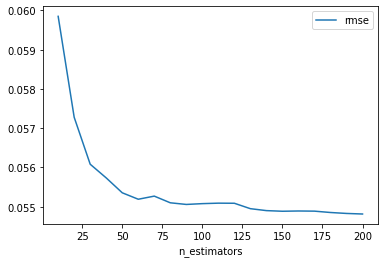

In [102]:
#@ INSPECTING THE RMSE SCORES:
df_results = pd.DataFrame(data=results, columns=['n_estimators', 'rmse'])
plt.plot(df_results.n_estimators, df_results.rmse, label='rmse')
plt.xlabel('n_estimators')
# plt.ylim(0.82, 0.84)
plt.legend()

- After which value of `n_estimators` does RMSE stop improving?

- Answer: 70?

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [103]:
#@ TRAINING THE MODEL WITH DEPTH:
results = []

for n_estimators in np.arange(10, 201, 10):
  for max_depth in [10,15,20,25]:
    rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=1, n_jobs=-1)
    rfr.fit(x_train, y_train)
    y_pred = rfr.predict(x_val)
    rmse = mean_squared_error(y_val, y_pred)
    print(f"n_estimators = {n_estimators} rmse = {rmse}, max_depth = {max_depth}")
    results.append((n_estimators, rmse, max_depth))

n_estimators = 10 rmse = 0.06654258777387133, max_depth = 10
n_estimators = 10 rmse = 0.060155106236857755, max_depth = 15
n_estimators = 10 rmse = 0.0600241797634644, max_depth = 20
n_estimators = 10 rmse = 0.06016900103881088, max_depth = 25
n_estimators = 20 rmse = 0.06575511345410755, max_depth = 10
n_estimators = 20 rmse = 0.05810963354328709, max_depth = 15
n_estimators = 20 rmse = 0.05747236277363688, max_depth = 20
n_estimators = 20 rmse = 0.057575509563370125, max_depth = 25
n_estimators = 30 rmse = 0.06528456430001019, max_depth = 10
n_estimators = 30 rmse = 0.0571982008568739, max_depth = 15
n_estimators = 30 rmse = 0.0561669130993882, max_depth = 20
n_estimators = 30 rmse = 0.056137479960078784, max_depth = 25
n_estimators = 40 rmse = 0.06503524037484723, max_depth = 10
n_estimators = 40 rmse = 0.05671660938822793, max_depth = 15
n_estimators = 40 rmse = 0.05572916197296561, max_depth = 20
n_estimators = 40 rmse = 0.05563038238824882, max_depth = 25
n_estimators = 50 rmse =

Text(0, 0.5, 'rmse')

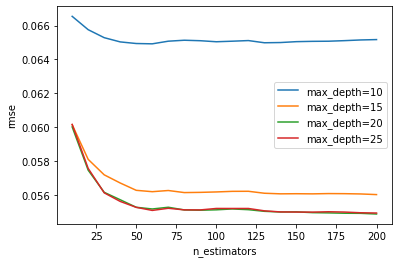

In [112]:
df_results = pd.DataFrame(data=results, columns=['n_estimators', 'rmse', 'max_depth'])
for max_depth in [10,15,20,25]:
  score = df_results[df_results.max_depth == max_depth]
  plt.plot(score.n_estimators, score.rmse, label=f'max_depth={max_depth}')
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('rmse')

- What's the best `max_depth`:

- Answer: 20

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

In [118]:
#@ TRAINING THE RANDOM FOREST MODEL:
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rfr.fit(x_train, y_train)
y_pred = rfr.predict(x_val)
rmse = mean_squared_error(y_val, y_pred)


None


In [160]:

feature_importances_ = rfr.feature_importances_
feature_importances_.sort()
best = feature_importances_[-1]
importance = dict(zip(rfr.feature_importances_, dv.feature_names_))
importance[best]

'median_income'

- What's the most important feature?

- Answer: median_income

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [176]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)
watchlist = [(dtrain,'train'),(dval, 'eval')]
model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, verbose_eval=5)

[0]	train-rmse:10.44507	eval-rmse:10.42647
[5]	train-rmse:6.17559	eval-rmse:6.16168
[10]	train-rmse:3.65737	eval-rmse:3.64675
[15]	train-rmse:2.17439	eval-rmse:2.16530
[20]	train-rmse:1.30457	eval-rmse:1.29844
[25]	train-rmse:0.80057	eval-rmse:0.79813
[30]	train-rmse:0.51518	eval-rmse:0.51762
[35]	train-rmse:0.35972	eval-rmse:0.36832
[40]	train-rmse:0.28219	eval-rmse:0.29788
[45]	train-rmse:0.24608	eval-rmse:0.26759
[50]	train-rmse:0.22963	eval-rmse:0.25508
[55]	train-rmse:0.22036	eval-rmse:0.24930
[60]	train-rmse:0.21470	eval-rmse:0.24633
[65]	train-rmse:0.20987	eval-rmse:0.24391
[70]	train-rmse:0.20573	eval-rmse:0.24223
[75]	train-rmse:0.20157	eval-rmse:0.24020
[80]	train-rmse:0.19805	eval-rmse:0.23898
[85]	train-rmse:0.19482	eval-rmse:0.23757
[90]	train-rmse:0.19191	eval-rmse:0.23594
[95]	train-rmse:0.18933	eval-rmse:0.23538
[99]	train-rmse:0.18758	eval-rmse:0.23446


- Now, change eta first to 0.1 and then to 0.01.

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: 0.3